Imagine you are tasked with allocating funds for diaster risk response in relation to hurricanes striking the USA. The committe want to know how much they should plan to put aside each year to rebuild from major hurricanes -- causing damage significant enough that federal assistance is required. 

To answer this, then, we need to know the **expected cost/year** from major tropical cyclone. 

There are two parts to the above: 

(1) What is the **expected cost** of a major tropical cylone?

(2) How often to major tropical cyclones strike each year? (i.e., what is the annual frequency)

To answer the above, we just need to compute the mean cost per major tropical cyclone, and then multiply by the annual frequency of tropical cyclones (i.e., the number of . 

In [220]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
data=pd.read_csv("Data/HurricaneDamage.csv",index_col="lf_ISO_TIME",parse_dates=True)
data["ND"]/=1e9
data=data.loc[data["ND"]>16.]
cost=data["ND"].values[:]
years=np.unique(data.index.year)

In [198]:
shape,loc,scale=stats.genpareto.fit(cost)
refcost=np.linspace(np.min(cost),1e3,1000)
p=stats.genpareto.pdf(refcost,shape,loc=loc,scale=scale)

Text(0.5, 0, 'Damage (2018 $Bn)')

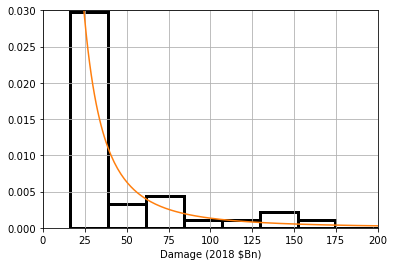

In [209]:
fig,ax=plt.subplots(1,1)
ax.hist(cost,bins=10,density=True,facecolor='w',edgecolor='k',linewidth=3)
ax.plot(refcost,p)
ax.set_ylim(0,0.03)
ax.set_xlim(0,200)
ax.grid()
ax.set_xlabel("Damage (2018 $Bn)")

40.75720180901202


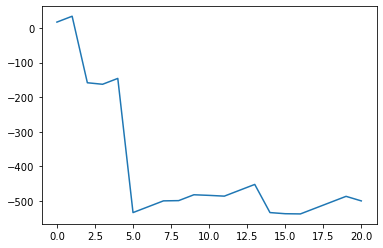

In [397]:
nsim=20
crit=-200 # Bn
balance=np.zeros(nsim+1)*np.nan
tracked=np.zeros(len(balance))
impact=0
E=np.mean(cost)
ny=np.max(years)-np.min(years)+1
E=np.mean(cost)
alloc=E*ne/ny
balance[0]=alloc
for i in range(1,nsim+1):
    if np.random.uniform(low=0,high=1)<=pyr:
        impact=stats.genpareto.rvs(shape,loc=loc,scale=scale,size=1)
    else: impact =0
    tracked[i]=impact
    balance[i]=balance[i-1]+alloc-impact
print(np.mean(tracked))
plt.plot(balance)

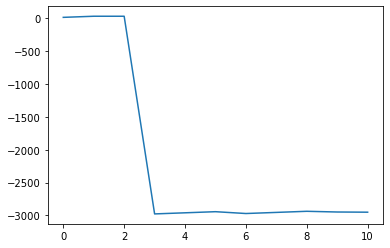

In [263]:
plt.plot(balance)

In [ ]:
# Repeat with the normal distribution


Can you explain what is going on?

What lessons can be learned regarding climate risk?

Covid is another fat-tailed risk. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7533687/